<a href="https://colab.research.google.com/github/zilavalencia/ChungaraVZila-IA-SIS420/blob/main/Laboratorios/LAB07_GYMNASIUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LABORATORIO 7

ESTUDIANTES:

Portillo Mercado Daniela

Chungara Valencia Zila

# 1. Importaciones básicas y configuración para Google Colab

Esta primera celda configura el entorno base del cuaderno. Incluye bibliotecas esenciales para trabajar con aprendizaje por refuerzo, visualización y manipulación de datos. También asegura que los gráficos se muestren correctamente dentro del cuaderno al trabajar en Google Colab, mediante %matplotlib inline. La biblioteca gymnasium es fundamental, ya que contiene el entorno Pendulum-v1 donde se entrenarán los agentes

In [ ]:
# Importaciones básicas
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import random
import math

# Asegurar gráficos en Colab
%matplotlib inline


# Función para graficar recompensas por episodio

Esta función se encarga de visualizar el desempeño del agente durante el entrenamiento, mostrando cómo evoluciona la recompensa acumulada en cada episodio.

Primero, se grafica la línea de recompensas crudas, es decir, la recompensa obtenida episodio por episodio. Sin embargo, como esa información puede ser ruidosa y difícil de interpretar, se agrega una media móvil suavizada (con una ventana de 20 episodios) para observar mejor la tendencia general de aprendizaje del agente.

También se incluyen etiquetas, título, rejilla y una leyenda para mejorar la presentación del gráfico.

In [ ]:
def plot_rewards(rewards, title="Recompensas por episodio"):
    plt.figure(figsize=(10,5))
    plt.plot(rewards, alpha=0.3, label='Recompensa por episodio')
    window = 20
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(len(smoothed)), smoothed, linewidth=2, label='Media móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa acumulada')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# Función: visualizar_q(agent, num_estados=5)

Esta función permite ver una muestra representativa de la tabla Q aprendida por el agente. Como la Q-table puede ser muy grande (especialmente si hay muchos estados y acciones), esta función muestra solo los primeros num_estados para su inspección.



Muestra la técnica utilizada (por ejemplo: incremental, ucb, etc.).

Toma los primeros num_estados del diccionario de valores Q (q_values), donde las claves son estados discretizados.

Para cada uno de esos estados, convierte sus acciones y valores Q en un DataFrame de Pandas para una visualización más limpia.

Redondea los valores a dos decimales para mejorar la legibilidad, y reemplaza valores NaN con un guion si alguna acción no ha sido explorada todavía.



In [ ]:
def visualizar_q(agent, num_estados=5):
    print(f"\n📊 Muestra de Q-table (técnica='{agent.technique}', {num_estados} estados):")
    estados = list(agent.q_values.keys())[:num_estados]
    for s in estados:
        acciones = agent.q_values[s]
        df = pd.DataFrame([acciones])
        print(f"Estado {s}:")
        display(df.round(2).fillna('-'))


# Implementación del Agente

La clase PendulumExplorationAgent encapsula todo el comportamiento del agente que aprende en un entorno continuo discretizado. Soporta múltiples técnicas de exploración, lo que me permitió comparar métodos como Q-learning clásico, exploración optimista, UCB y softmax. El método train permite medir cómo mejora el agente en términos de recompensa, mientras que los métodos select_action y update gestionan el balance entre exploración y explotación. Elegí discretizar el espacio de estados y acciones para aplicar Q-learning, ya que el entorno es continuo

Hiperparámetros (configuraciones externas)
Los hiperparámetros son valores definidos al inicio y no cambian durante el entrenamiento. Algunos de los más importantes son:

* **alpha: **define qué tan rápido aprende el agente. Cuanto más alto, más peso le da a nuevas experiencias.

* **gamma**: determina qué tanto valora las recompensas futuras.

* **epsilon:** se usa en la estrategia ε-greedy para decidir si el agente explora o explota.

* **state_bins y action_bins:** son responsables de discretizar el espacio continuo, dividiendo el estado y las acciones en bloques manejables.

* **initial_q:** se usa en la estrategia optimistic para empezar con valores altos y fomentar la exploración.

 * c: se usa en ucb para controlar el nivel de confianza que se requiere para explorar acciones nuevas.



🗃️ Variables internas del agente
Estas variables cambian durante el entrenamiento:

+ q_values: es la tabla Q que guarda los valores aprendidos para cada combinación de estado y acción.

+ action_counts: registra cuántas veces se ha ejecutado cada acción en cada estado. Es clave para el método UCB.

* preferences: almacena las preferencias de acciones por estado, utilizado solo en el enfoque basado en gradiente.

* baseline: ayuda a estabilizar el aprendizaje en el enfoque de política (gradient).

* total_steps: cuenta cuántos pasos totales ha dado el agente en su entrenamiento.


📊 Estrategias de exploración
Cada estrategia representa una manera distinta de balancear la exploración (probar cosas nuevas) con la explotación (usar lo aprendido):

* **Incremental:** usa Q-learning tradicional con la estrategia ε-greedy. A veces elige la mejor acción, otras veces una aleatoria.

* **Optimistic:** inicializa la tabla Q con valores altos para que el agente explore más al principio.

* **UCB** (Upper Confidence Bound): elige acciones según una fórmula que combina el valor Q con un “bonus” que premia las acciones menos exploradas.

* **Gradient** (política): usa softmax para asignar probabilidades a cada acción y actualiza estas probabilidades según el rendimiento (usando una técnica inspirada en REINFORCE).


💬 Explicación adicional
Este agente es muy completo porque:

Convierte un entorno continuo en uno discretizado, lo que permite usar técnicas clásicas.

Permite probar y comparar diferentes estrategias de exploración.

Es ideal para entornos de simulación donde queremos estudiar cómo afecta cada tipo de exploración al rendimiento del agente.

Además, la estructura modular del código permite ajustar fácilmente cada parámetro y observar cómo cambian los resultados en las gráficas o durante el entrenamiento.

In [ ]:
class PendulumExplorationAgent:
    def __init__(self, env, technique='incremental', **kwargs):
        self.env = env  # Entorno de OpenAI Gym donde el agente interactúa
        self.technique = technique  # Técnica de exploración-explotación usada ('incremental', 'optimistic', 'ucb', 'gradient')

        # Discretización del espacio de estados y acciones
        self.state_bins = kwargs.get('state_bins', [10,10,10])  # Número de bins por cada dimensión del estado
        self.action_bins = kwargs.get('action_bins', 21)  # Número de acciones discretas posibles
        self.state_ranges = [(-1,1),(-1,1),(-8,8)]  # Rango para cada dimensión del estado (pendulum tiene 3 variables)
        self.action_range = (-2,2)  # Rango de acciones continuas posibles

        # Parámetros de aprendizaje y exploración
        self.alpha = kwargs.get('alpha', 0.1)  # Tasa de aprendizaje
        self.gamma = kwargs.get('gamma', 0.95)  # Factor de descuento
        self.epsilon = kwargs.get('epsilon', 0.1)  # Probabilidad de exploración (para técnicas epsilon-greedy)
        self.c = kwargs.get('c', 2.0)  # Parámetro para UCB (control de exploración)
        self.initial_q = kwargs.get('initial_q', 10.0)  # Valor inicial optimista para Q (en técnica optimista)

        # Estructuras para almacenar valores Q, conteo de acciones, preferencias para gradiente, etc.
        self.q_values = defaultdict(lambda: defaultdict(float))  # Tabla Q: estado -> acción -> valor
        self.action_counts = defaultdict(lambda: defaultdict(int))  # Conteo de veces que se eligió acción en estado
        self.preferences = defaultdict(lambda: defaultdict(float))  # Preferencias para política basada en gradiente
        self.baseline = 0.0  # Baseline para reducción de varianza en método de gradiente
        self.total_steps = 0  # Contador global de pasos

        # Inicialización optimista de Q si se usa técnica 'optimistic'
        if technique=='optimistic':
            for s in range(np.prod(self.state_bins)):  # Por cada estado discretizado
                state = tuple(np.unravel_index(s, self.state_bins))
                for a in range(self.action_bins):
                    self.q_values[state][a] = self.initial_q  # Se asigna valor alto para fomentar exploración

        print(f"Técnica seleccionada: {technique}")

    def discretize_state(self, obs):
        # Convierte estado continuo en estado discreto usando bins definidos en state_ranges y state_bins
        bins = []
        for i,val in enumerate(obs):
            low,high = self.state_ranges[i]
            edges = np.linspace(low, high, self.state_bins[i]+1)[1:-1]  # Bordes internos de los bins
            bins.append(np.digitize(val,edges))  # Obtiene índice del bin para el valor
        return tuple(bins)

    def continuous_action(self, a_idx):
        # Convierte índice de acción discreta a valor continuo en rango definido
        low,high = self.action_range
        step = (high - low) / (self.action_bins - 1)
        return low + a_idx * step

    def select_action(self, state):
        # Selecciona acción según la técnica de exploración-explotación
        if self.technique in ['incremental','optimistic']:
            # Epsilon-greedy: con probabilidad epsilon explora, sino explota mejor acción
            if np.random.rand() < self.epsilon:
                return np.random.randint(self.action_bins)
            qv = self.q_values[state]
            maxq = max(qv.values()) if qv else 0
            actions = [a for a,q in qv.items() if q==maxq]
            return np.random.choice(actions) if actions else np.random.randint(self.action_bins)

        elif self.technique=='ucb':
            # Upper Confidence Bound: añade término de incertidumbre para exploración
            total = sum(self.action_counts[state].values()) + 1
            ucbv = {
                a: self.q_values[state][a] +
                   self.c * np.sqrt(np.log(total)/(self.action_counts[state][a]+1e-5))
                for a in range(self.action_bins)
            }
            maxucb = max(ucbv.values())
            actions = [a for a,val in ucbv.items() if val==maxucb]
            return np.random.choice(actions)

        else:  # gradient (política basada en gradiente)
            prefs = np.array([self.preferences[state][a] for a in range(self.action_bins)])
            prefs -= prefs.max()  # Estabilización numérica para softmax
            probs = np.exp(prefs) / np.sum(np.exp(prefs))  # Probabilidades para cada acción
            return np.random.choice(range(self.action_bins), p=probs)

    def update(self, s, a, r, s2):
        self.total_steps += 1

        if self.technique in ['incremental','optimistic','ucb']:
            # Actualización clásica Q-learning
            maxq = max(self.q_values[s2].values()) if self.q_values[s2] else 0
            target = r + self.gamma * maxq
            self.q_values[s][a] += self.alpha * (target - self.q_values[s][a])
            self.action_counts[s][a] += 1

        else:  # gradient
            # Actualización basada en gradiente de la política (REINFORCE)
            prefs = np.array([self.preferences[s][a_] for a_ in range(self.action_bins)])
            prefs -= prefs.max()
            probs = np.exp(prefs) / np.sum(np.exp(prefs))
            baseline_old = self.baseline
            self.baseline += self.alpha * (r - self.baseline)  # Actualización del baseline
            for a_ in range(self.action_bins):
                grad = (1 if a_==a else 0) - probs[a_]
                self.preferences[s][a_] += self.alpha * (r - baseline_old) * grad

    def train(self, episodes=500, max_steps=200):
        rewards = []
        for ep in range(episodes):
            obs,_ = self.env.reset()
            s = self.discretize_state(obs)
            total_r = 0
            for _ in range(max_steps):
                a = self.select_action(s)  # Elegir acción
                act = self.continuous_action(a)  # Acción en valor continuo
                obs2,r,done,trunc,_ = self.env.step([act])  # Ejecutar acción en el entorno
                s2 = self.discretize_state(obs2)  # Discretizar nuevo estado
                self.update(s,a,r,s2)  # Actualizar valores según técnica
                s = s2
                total_r += r
                if done or trunc:
                    break
            rewards.append(total_r)
            if ep % 100 == 0:
                print(f"Episodio {ep}, recompensa media últimos 100: {np.mean(rewards[-100:]):.2f}")
        return rewards


Esta función encapsula todo el proceso de:

Crear el entorno,

Configurar el agente,

Entrenar y

Evaluar el rendimiento visualmente.

Es especialmente útil para comparar diferentes técnicas de exploración de forma sencilla. Solo necesitas llamar a train_and_plot("nombre_técnica").

In [ ]:
def train_and_plot(technique):
    env = gym.make('Pendulum-v1')
    agent = PendulumExplorationAgent(env, technique=technique)
    rewards = agent.train(episodes=500)
    plot_rewards(rewards, title=f"Técnica: {technique}")
    return agent, rewards


Esta función está diseñada para entrenar y comparar varias técnicas de aprendizaje por refuerzo en el entorno del péndulo, automatizando el proceso para facilitar el análisis comparativo.

In [ ]:
def compare_techniques():
    results = {}
    for tech in ['incremental','optimistic','ucb','gradient']:
        print(f"\n=== Entrenando técnica: {tech} ===")
        agent, rewards = train_and_plot(tech)
        results[tech] = (agent, rewards)
    return results


# Ejecutar el entrenamiento y guardar resultados
* Permite comparar visualmente la eficiencia y estabilidad de cada técnica a lo largo del entrenamiento.

* Facilita observar cuál método converge más rápido, cuál alcanza mejores recompensas y cuál es más estable.

* Da una visión general del desempeño relativo para fundamentar conclusiones sobre el mejor método para el entorno y problema planteado.





=== Entrenando técnica: incremental ===
Técnica seleccionada: incremental
Episodio 0, recompensa media últimos 100: -875.43
Episodio 100, recompensa media últimos 100: -1212.77
Episodio 200, recompensa media últimos 100: -1203.11
Episodio 300, recompensa media últimos 100: -1167.71
Episodio 400, recompensa media últimos 100: -1169.50


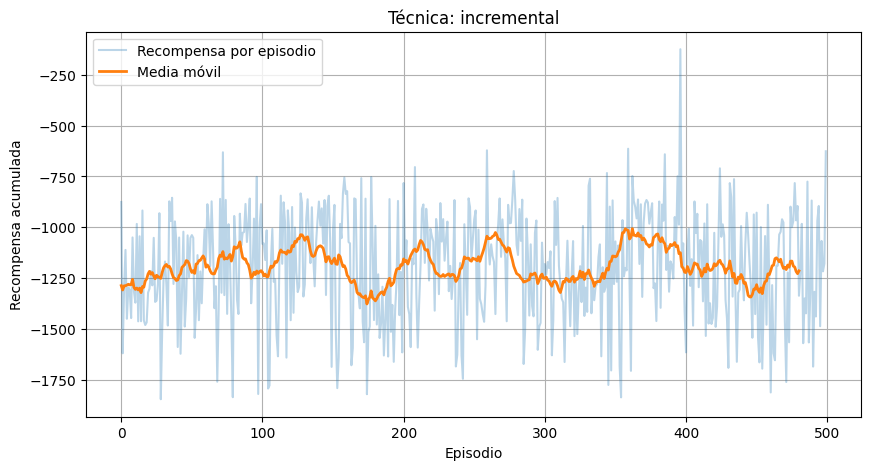


=== Entrenando técnica: optimistic ===
Técnica seleccionada: optimistic
Episodio 0, recompensa media últimos 100: -963.73
Episodio 100, recompensa media últimos 100: -1211.72
Episodio 200, recompensa media últimos 100: -1238.04
Episodio 300, recompensa media últimos 100: -1207.30
Episodio 400, recompensa media últimos 100: -1186.54


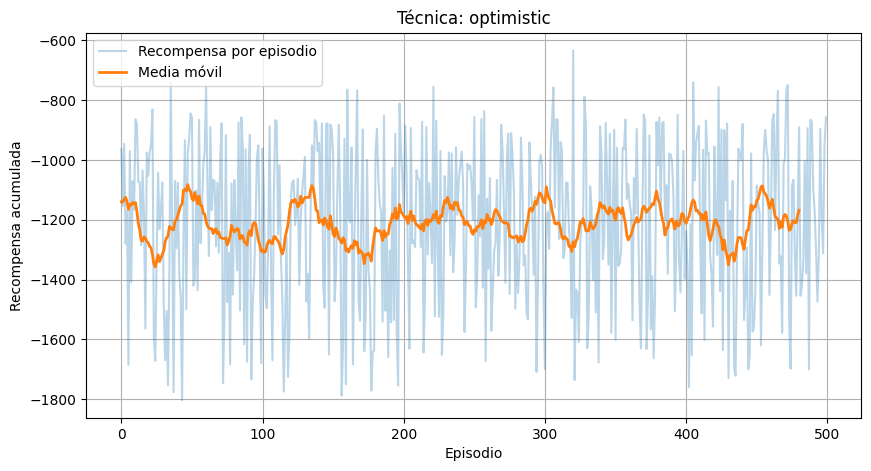


=== Entrenando técnica: ucb ===
Técnica seleccionada: ucb
Episodio 0, recompensa media últimos 100: -1214.84
Episodio 100, recompensa media últimos 100: -1219.38
Episodio 200, recompensa media últimos 100: -1265.10
Episodio 300, recompensa media últimos 100: -1155.46
Episodio 400, recompensa media últimos 100: -1213.47


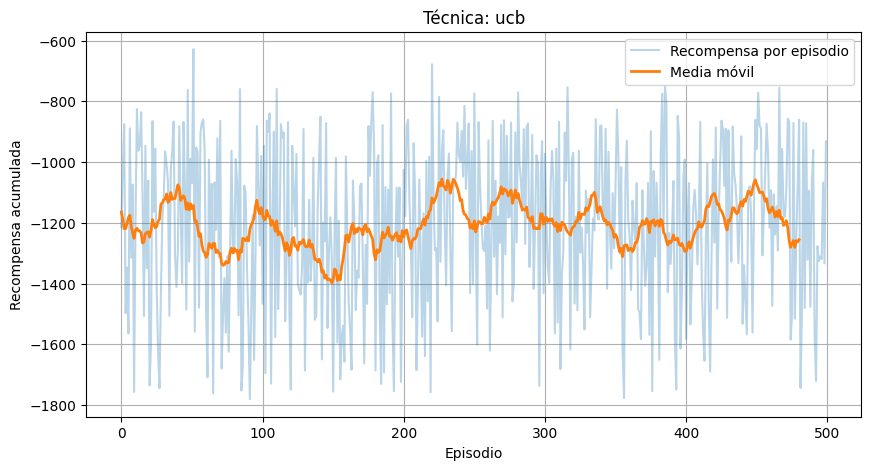


=== Entrenando técnica: gradient ===
Técnica seleccionada: gradient
Episodio 0, recompensa media últimos 100: -1108.63
Episodio 100, recompensa media últimos 100: -1227.66
Episodio 200, recompensa media últimos 100: -1140.39
Episodio 300, recompensa media últimos 100: -1163.73
Episodio 400, recompensa media últimos 100: -1215.49


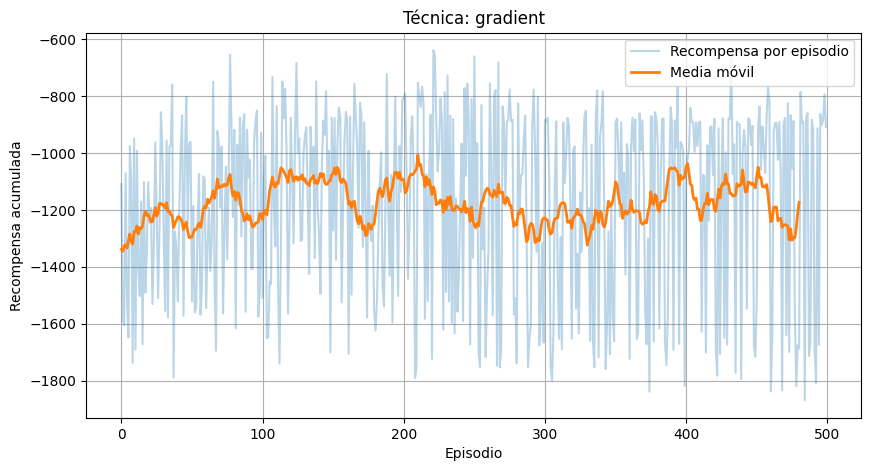

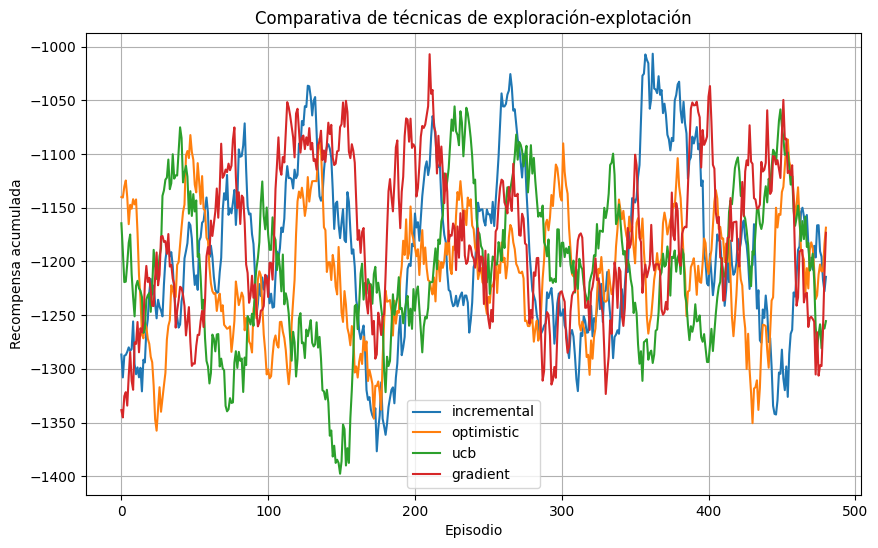

In [ ]:
all_results = compare_techniques()

plt.figure(figsize=(10,6))
for tech, (_, rewards) in all_results.items():
    sm = np.convolve(rewards, np.ones(20)/20, mode='valid')
    plt.plot(sm, label=tech)
plt.title("Comparativa de técnicas de exploración-explotación")
plt.xlabel("Episodio")
plt.ylabel("Recompensa acumulada")
plt.grid(True)
plt.legend()
plt.show()


# Visualización de tablas Q para técnicas basadas en Q-table

La tabla Q es la estructura clave en los métodos de aprendizaje Q-learning:
almacena el conocimiento aprendido sobre la calidad de cada acción en cada estado.

Mostrarla permite:

Verificar visualmente cómo se distribuyen los valores Q

Comprobar que el agente realmente ha aprendido algo sobre el entorno y las acciones óptimas.

Entender las diferencias en el aprendizaje según la técnica usada.

In [ ]:
# Solo para técnicas con Q-table
agent_inc = all_results['incremental'][0]
agent_opt = all_results['optimistic'][0]
agent_ucb = all_results['ucb'][0]

visualizar_q(agent_inc)
visualizar_q(agent_opt)
visualizar_q(agent_ucb)



📊 Muestra de Q-table (técnica='incremental', 5 estados):
Estado (np.int64(9), np.int64(4), np.int64(4)):


,8,17,12,10,3,6,9,0,16,19,5,14,13,11,7,1,2,18,15
0,-0.34,-0.3,-0.3,-0.31,-0.4,-0.3,-0.3,-0.36,-0.27,-0.31,-0.34,-0.31,-0.3,-0.34,-0.32,-0.31,-0.35,-0.08,-0.09


Estado (np.int64(9), np.int64(3), np.int64(4)):


,20,12,13,9,1,10,3,19,15,18,2,14,11,17,16,0,8,6
0,-0.45,-0.67,-0.68,-0.65,-0.64,-0.69,-0.64,-0.64,-0.63,-0.72,-0.68,-0.73,-0.61,-0.64,-0.63,-0.68,-0.7,-0.66


Estado (np.int64(9), np.int64(2), np.int64(4)):


,6,1,13,10,20,0,15,8,19,4,16,14,18,9,2,17,12
0,-1.66,-1.57,-1.52,-1.48,-1.48,-1.68,-1.51,-1.52,-1.53,-1.58,-1.48,-1.46,-1.48,-1.59,-1.5,-1.5,-1.73


Estado (np.int64(9), np.int64(2), np.int64(3)):


,5,9,10,8,1,0,2,12,20,11,14,3,16,13,17,19,15
0,-2.42,-2.35,-2.28,-2.33,-2.31,-2.48,-2.33,-2.31,-2.53,-2.52,-2.34,-2.37,-2.4,-2.36,-2.33,-2.46,-2.34


Estado (np.int64(8), np.int64(1), np.int64(3)):


,9,10,18,3,2,8,13,12,15,20,1,7,11,14,0,4,6,19,5
0,-3.82,-3.91,-3.89,-3.82,-3.87,-3.96,-3.84,-3.96,-3.96,-3.99,-3.85,-4.1,-3.91,-3.96,-3.91,-4.32,-3.86,-4.03,-0.64



📊 Muestra de Q-table (técnica='optimistic', 5 estados):
Estado (np.int64(0), np.int64(0), np.int64(0)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Estado (np.int64(0), np.int64(0), np.int64(1)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Estado (np.int64(0), np.int64(0), np.int64(2)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Estado (np.int64(0), np.int64(0), np.int64(3)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Estado (np.int64(0), np.int64(0), np.int64(4)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0



📊 Muestra de Q-table (técnica='ucb', 5 estados):
Estado (np.int64(2), np.int64(0), np.int64(5)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-13.47,-13.3,-13.24,-13.69,-13.62,-13.51,-13.51,-13.5,-13.33,-13.49,...,-13.01,-13.12,-13.43,-13.31,-13.28,-13.19,-13.31,-13.2,-13.6,-13.28


Estado (np.int64(2), np.int64(0), np.int64(4)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-15.43,-15.51,-15.71,-16.19,-16.34,-15.75,-15.46,-16.38,-15.89,-15.86,...,-15.47,-15.52,-15.83,-15.72,-15.65,-16.22,-15.6,-15.69,-16.19,-15.85


Estado (np.int64(1), np.int64(1), np.int64(4)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-22.98,-22.97,-23.11,-23.2,-22.91,-22.97,-22.92,-22.96,-23.49,-23.21,...,-23.02,-23.52,-22.82,-23.12,-23.49,-23.41,-22.85,-22.97,-23.17,-22.84


Estado (np.int64(1), np.int64(1), np.int64(3)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-22.3,-21.82,-21.79,-22.09,-21.89,-22.21,-22.15,-22.26,-22.07,-22.02,...,-22.41,-22.12,-22.31,-21.95,-22.24,-21.98,-22.3,-22.53,-21.91,-22.27


Estado (np.int64(0), np.int64(2), np.int64(3)):


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-25.63,-25.4,-25.15,-25.32,-25.24,-25.47,-25.0,-24.89,-25.07,-25.14,...,-25.45,-25.1,-24.99,-25.64,-25.65,-25.82,-25.19,-24.89,-25.72,-25.16


# Mostrar la política
Esta función tiene como propósito mostrar la política aprendida por un agente basado en Q-learning.

La política es una función que indica cuál es la acción óptima a tomar en cada estado dado, según el conocimiento aprendido.

In [ ]:
def mostrar_politica(agent, num_estados=5):
    print(f"\n📌 Política aprendida (técnica: {agent.technique}):")
    estados = list(agent.q_values.keys())[:num_estados]
    for s in estados:
        qv = agent.q_values[s]
        a_star = max(qv, key=qv.get)
        print(f"Estado {s} → Acción óptima: {a_star}")


In [ ]:
mostrar_politica(agent_inc)



📌 Política aprendida (técnica: incremental):
Estado (np.int64(9), np.int64(4), np.int64(4)) → Acción óptima: 18
Estado (np.int64(9), np.int64(3), np.int64(4)) → Acción óptima: 20
Estado (np.int64(9), np.int64(2), np.int64(4)) → Acción óptima: 14
Estado (np.int64(9), np.int64(2), np.int64(3)) → Acción óptima: 10
Estado (np.int64(8), np.int64(1), np.int64(3)) → Acción óptima: 5


# Explotación del agente entrenado

In [ ]:
# Explotación del agente entrenado para los agentes con Q-table

print("\n=== Explotación del agente entrenado (Incremental) ===")
run_episode(agent_inc, render=False)

print("\n=== Explotación del agente entrenado (Optimistic) ===")
run_episode(agent_opt, render=False)

print("\n=== Explotación del agente entrenado (UCB) ===")
run_episode(agent_ucb, render=False)



=== Explotación del agente entrenado (Incremental) ===
Recompensa total en episodio de explotación: -1399.64 (pasos: 200)

=== Explotación del agente entrenado (Optimistic) ===
Recompensa total en episodio de explotación: -859.16 (pasos: 200)

=== Explotación del agente entrenado (UCB) ===
Recompensa total en episodio de explotación: -1259.17 (pasos: 200)


np.float64(-1259.1747896322709)

In [ ]:
def run_episode(agent, render=False, max_steps=200):
    obs,_ = agent.env.reset()
    s = agent.discretize_state(obs)
    total_r = 0
    done = False
    steps = 0
    while not done and steps < max_steps:
        a = agent.select_action(s)
        act = agent.continuous_action(a)
        obs2,r,done,trunc,_ = agent.env.step([act])
        s = agent.discretize_state(obs2)
        total_r += r
        steps += 1
        if render:
            agent.env.render()
    print(f"Recompensa total en episodio de explotación: {total_r:.2f} (pasos: {steps})")
    return total_r



In [ ]:
run_episode(agent_inc, render=False)


Recompensa total en episodio de explotación: -1387.98 (pasos: 200)


np.float64(-1387.980580625654)